<div class="alert alert-block alert-info" style="font-size:20px; background-color: #fffcc7; font-family:verdana; color: #636135; border: 3px #636135 solid">
    <b>Simple GANs</b>
    <br>Vamos a ver un ejemplo de cómo generar una GAN sencilla<br>
</div>


In [89]:
# Instalamos las librerías necesarias
#!pip install torch torchvision seaborn numpy matplotlib opencv-python
#!pip install --upgrade ipywidgets
#!pip install jupyterlab_widgets
#!pip install notebook
#!jupyter contrib nbextension install
#!jupyter nbextension enable --py widgetsnbextension

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Importamos librerías</b>
</div>


In [90]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_theme(style='darkgrid', font_scale=1.2)

In [91]:
print(os.getcwd())
DATA_DIR = 'D:\ProyectosPython\data\cats'


d:\ProyectosPython\GANs


<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
<p>Tamaño de las imagenes, del batch a procesar y estadisticas para la normalización (dos tuplas de tres elementos cada una, donde la primera tupla (0.5, 0.5, 0.5) son las medias y la segunda tupla (0.5, 0.5, 0.5) son las desviaciones estándar para los tres canales de color (RGB) de las imágenes.)</p>
</div>

In [92]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Preparar los datos
<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Preparación de los datos</b>
    <p>
    La normalización de las imágenes se realiza sustrayendo la media de cada canal y dividiendo el resultado por la desviación estándar del canal correspondiente. Esto transforma los valores de los píxeles de manera que tengan aproximadamente una media de 0 y una desviación estándar de 1. stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) Esto ayudara a estabilizar el aprendizaje al asegurarse de que las entradas a la red estén en escalas similares.</p>
</div>


In [93]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
Crea un DataLoader para cargar datos en lotes, mezclando los datos (shuffle), con paralelización (num_workers) y optimización de memoria para GPUs (pin_memory).
</div>

In [94]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
La función denorm invierte la normalización de tensores de imágenes, reescalando y desplazando los valores de los píxeles a su rango original.
</div>

In [95]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
Funciones para mostrar la imagenes en un widget de pyplot
</div>

In [96]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>A ver cómo son las fotos:</b>
</div>


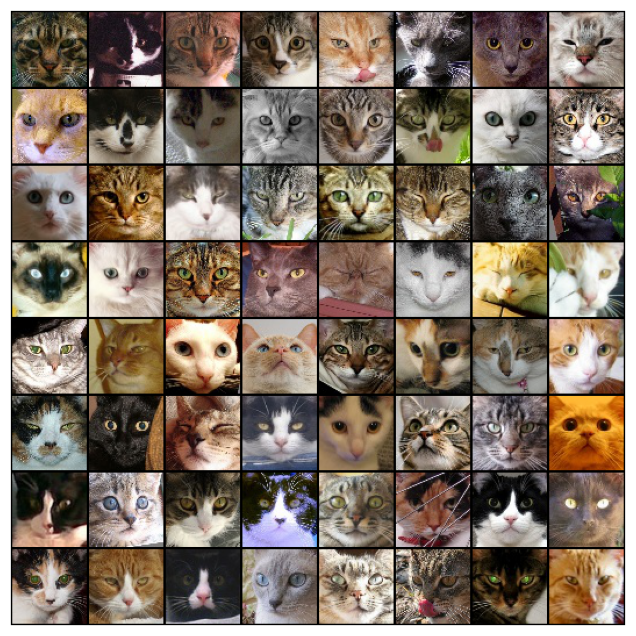

In [97]:
show_batch(train_dl)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Dataloader</b>
    <p>device: el destino al que se moverán los tensores. Este destino puede ser la memoria de la CPU o de una GPU disponible. DataLoader de pytorh tiene batches con los datos. Nuestra clase DEviceDataLoader permite iterar por sus instancias para usar to_device y llamar al método data.to(device) y mover los datos al dispositivo correcto antes de empezar a entrenar.</p>
</div>


In [98]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """cargador de datos para mover datos a un dispositivo"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Generar un lote de datos después de moverlo al dispositivo"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Numero de batches"""
        return len(self.dl)

In [99]:
# si tenemso gpu mejor... 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [100]:
train_dl = DeviceDataLoader(train_dl, device)

# Model
<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Vamos directamente a la construcción de la GAN</b>
    <br>Recuerda que la GAN consta de dos redes: un generador cuya tarea es aprender a generar imágenes similares a una muestra de entrenamiento a partir de ruido aleatorio, y un discriminador que aprende a reconocer si esta imagen es real o generada por el generador.<br>

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid; padding:20px">
    Construyamos un generador y un discriminador sobre convoluciones:
    El discriminador decide si las imagenes son verdaderas o fake.
    EL generador durante el entrenamiento intenta engañar al discriminador, hasta que lo consigue.
</div>

In [101]:
discriminador = nn.Sequential(
    # in: 3 x 64 x 64
    # nn.Conv2d(canales de entrada, canales de salida, stride (reduccion de dimensiones), dimensiones_espaciales (1 = mantener), bias)
    # 3 = RGB, 1 = escala de grises
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [102]:
discriminador = to_device(discriminador, device)

In [103]:
latent_size = 128

In [104]:
generador = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <p>A ver como es el ruido desde el que las imagenes serán generadas. </p>
    <p>Una GAN comienza con un ruido aleatorio y, a través de un proceso iterativo de aprendizaje entre dos redes (el generador y el discriminador), va modificando ese ruido. </p>
    <p>El generador intenta crear imágenes cada vez más parecidas a las reales, mientras que el discriminador evalúa si son reales o generadas. </p>
    <p>El proceso se repite hasta que el generador logra engañar al discriminador produciendo imágenes muy similares a las reales. </p>
    <p>Este proceso iterativo de mejora mutua entre generador y discriminador es lo que permite a la GAN aprender a generar imágenes que se asemejan a las del conjunto de entrenamiento.</p>
</div>

torch.Size([128, 3, 64, 64])


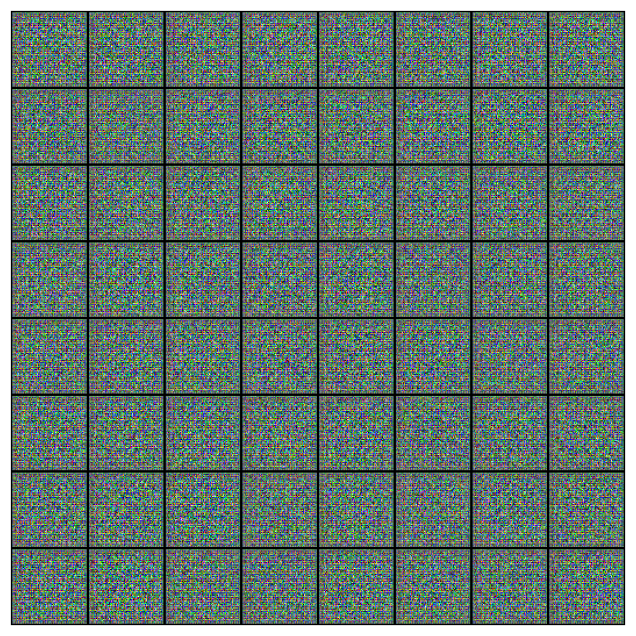

In [105]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generador(xb)
print(fake_images.shape)
show_images(fake_images)

In [106]:
generator = to_device(generador, device)

In [107]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [108]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [109]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Ahora pasemos a enseñar a nuestra GAN. El algoritmo de aprendizaje es el siguiente:</b>
<ul>
    <li>Enseñamos al discriminador:
        <ul>
            <li>tomamos imágenes reales y les asignamos la etiqueta 1</li>
            <li>generamos imágenes con un generador y les asignamos una etiqueta 0</li>
            <li>entrenamos al clasificador en dos clases</li>
        </ul>
    </li>
    <li>Enseñamos al generador:
        <ul>
            <li>generamos imágenes con un generador y les asignamos una etiqueta 0</li>
            <li>predecimos con un discriminador si esta imagen es real o no</li>
        </ul>
    </li>
</ul>
</div>

**Como función de pérdida, tomamos la entropía cruzada binaria**


![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/c40/568/876/c40568876434c2bcc933c2a5b7d29725.jpeg)

In [110]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Entrenamos el discriminador
            # Limpiamos gradientes
            optimizer["discriminator"].zero_grad()

            # Pasemo imagenes reales por el discriminador
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Geeramos imagenes falsas
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pasamos imagenes falsas por el discriminador
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Actualizamos los pesos del discriminador
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Entrenamos el generador
            # Limpiamos gradientes
            optimizer["generator"].zero_grad()
            
            # Generamos imagenes falsas
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Intentamos engañas al discriminador
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # actulizamos pesos
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # registramos puntuaciones y pérdindas
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # imprimios puntuaciones y pérdidas 
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Guardamos imagenes generadas
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
            
    # Guardamos el modelo y optimizadores al final del entrenamiento
    fecha_actual = datetime.now().strftime("%Y-%m-%d")
    nombre_archivo = f"modelo_difusion_gatos_{fecha_actual}.pth"
    torch.save({
        'discriminator_state_dict': model["discriminator"].state_dict(),
        'generator_state_dict': model["generator"].state_dict(),
        'optimizer_discriminator_state_dict': optimizer["discriminator"].state_dict(),
        'optimizer_generator_state_dict': optimizer["generator"].state_dict(),
        'losses_g': losses_g,
        'losses_d': losses_d,
        'real_scores': real_scores,
        'fake_scores': fake_scores,
    }, nombre_archivo)
    
    return losses_g, losses_d, real_scores, fake_scores

In [111]:
model = {
    "discriminator": discriminador.to(device),
    "generator": generador.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 55

### Si el modelo existe lo cargamos si no, entranmos uno nuevo

In [118]:
if (os.path.exists('modelo_difusion_gatos_2024-03-01.pth')):
    model_checkpoint = torch.load('modelo_difusion_gatos_2024-03-01.pth')
else:
    model_checkpoint = fit(model, criterion, epochs, lr)

# Predict
<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid; padding: 20px">
    Veamos la salida del aprendizaje. Así es como se ven las imagenes generadas en la última época de entrenamiento:
</div>

In [119]:

losses_g = model_checkpoint['losses_g']
losses_d = model_checkpoint['losses_d']
real_scores = model_checkpoint['real_scores']
fake_scores = model_checkpoint['fake_scores']

In [120]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

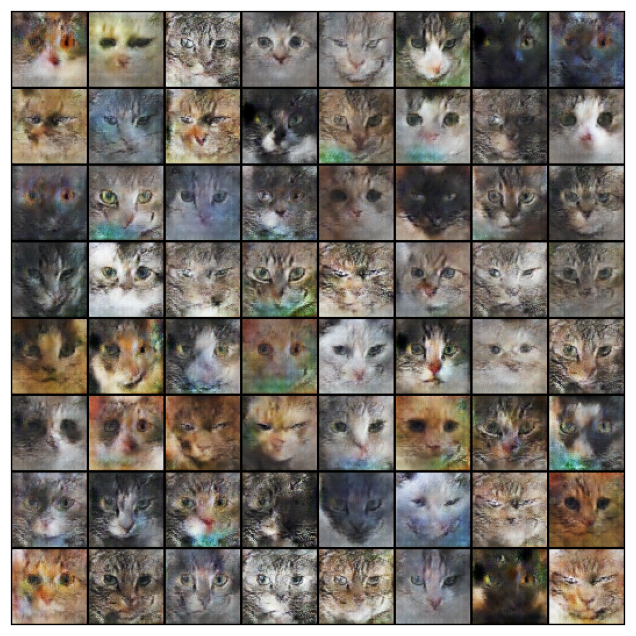

In [121]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

# Vamos a ver perdidas
<div style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid; padding:20px">
    La imagenes son similares a la muestra pero hay bastantes artefactos
    <br>Miremos las estadisticas de las pérdidas del generador y discriminador y puntuaciones<br>
</div>

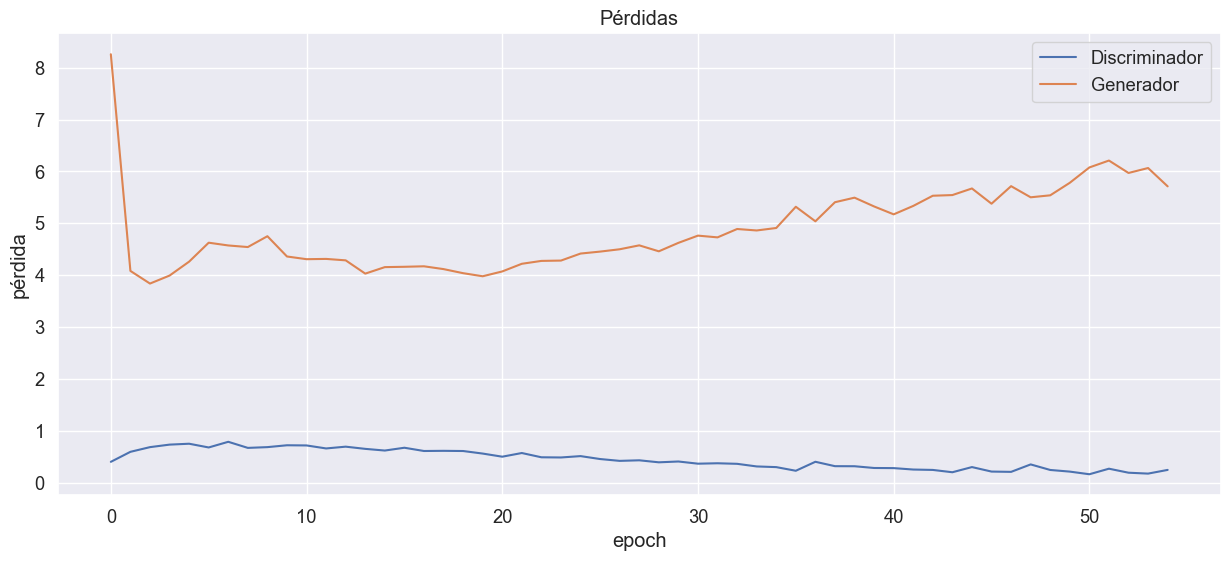

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('pérdida')
plt.legend(['Discriminador', 'Generador'])
plt.title('Pérdidas');

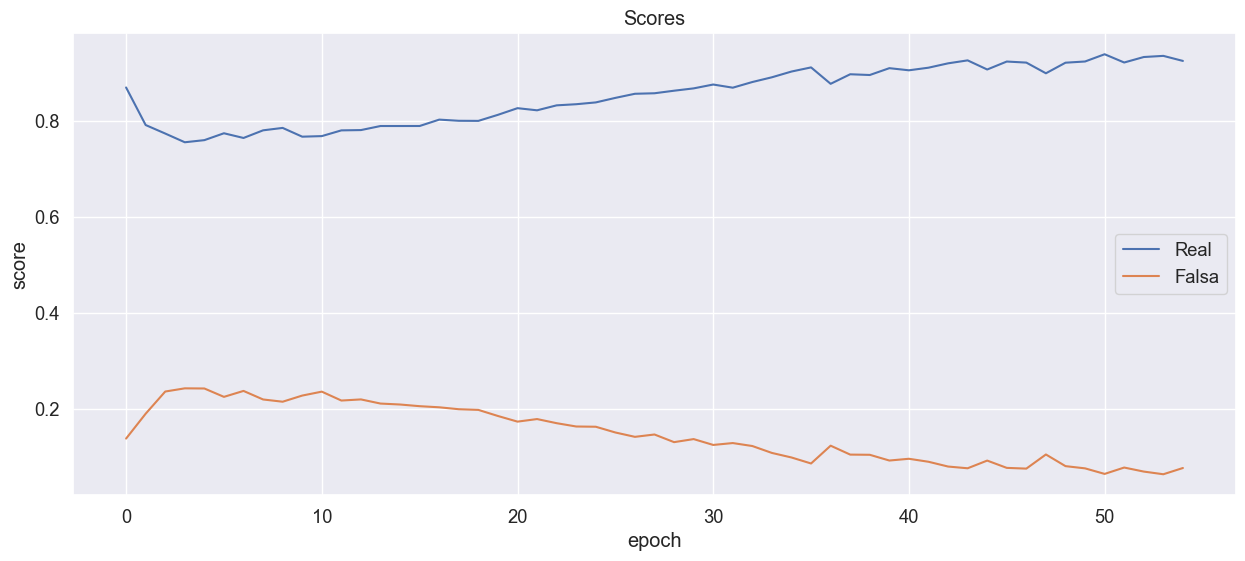

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Falsa'])
plt.title('Scores');